# <center>Mouse Brain from Neurons to brain regions</center>
## <center>application of co-simulation TVB-Nest multiscale</center>

<div class="alert alert-block alert-warning">
    <h1 id="Installation before usage">Installation before usage<a class="anchor-link" href="Installation-before-usage"></a>
        </h1>
    <h3><strong>You can't run the notebook on this platform.</strong></h3>
    <h3>The step for the installation is the following:</h3>
        <ul>
            <li>Install singularity : <a href=https://singularity.lbl.gov/quickstart> https://singularity.lbl.gov/quickstart </a></li>
          <li>Download the singularity notebook : <strong>Nest_TVB_full.simg</strong> and the notebook from the Storage of the Collab in <strong>one folder</strong></li>
          <li>Open an terminal in this folder</li>
          <li>Execute the next command : <strong>singularity run --app jupyter-notebook ./Nest_TVB_full.simg</strong></li>
          <li>Open the link of the jupyter notebook</li>
          <li>Open the notebook </li>
        </ul>
</div>

In [1]:
%matplotlib notebook
# library for the notebook
import matplotlib.pyplot as plt
import numpy as np
import os
# import library of the application
from nest_elephant_tvb.simulation.parameters_manager import save_parameter,create_linked_parameters
from nest_elephant_tvb.analyse.get_data import get_rate,get_data_all
from nest_elephant_tvb.analyse.neuron_widget import neuron_widget

# 1. Define the parameter of the simulation

In [2]:
param={}

## 1.1 parameter for Nest simulator

### 1.1.a parameter for Nest kernel (<a href=https://nest-simulator.readthedocs.io/en/nest-2.20.1/ref_material/pynest_apis.html#module-nest.lib.hl_api_simulation> documentation</a>)

In [3]:
param['param_nest'] = {
    "sim_resolution": 0.1,        # the precision of the simulation 
    "master_seed": 46,            # the seed for the random generator of Nest 
    "total_num_virtual_procs": 10,# the number of virtual processeur 
    "overwrite_files": True,      # 
    "print_time": True,           # print time (it's not working for the moment)
    "verbosity": 20}              # verbosity of Nest


### 1.1.b parameter of the neurons

This is a widget for helping to choice the good parameter for the adaptive exponential integrate and fire neuron <a id="parameter_neuron">

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=500;

<IPython.core.display.Javascript object>

In [5]:
neuron_widget(nb_thread=4)

interactive(children=(IntSlider(value=100, description='N_ex = Number of source neurons', layout=Layout(height…

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=100;

<IPython.core.display.Javascript object>

In [7]:
param['param_nest_topology'] = {
    "neuron_type": "aeif_cond_exp", # this model is the adaptive exponential 
                                    # integrate and fire neuron whith conductance
                                    # exponetial synapse (can be changed)
    "param_neuron_excitatory": {
        "C_m": 200.0, 
        "t_ref": 5.0,
        "V_reset": -64.5, 
        "E_L": -64.5,
        "g_L": 10.0, 
        "I_e": 0.0, 
        "a": 0.0, 
        "b": 1.0,
        "Delta_T": 2.0,
        "tau_w": 500.0, 
        "V_th": -50.0,
        "E_ex": 0.0, 
        "tau_syn_ex": 5.0, 
        "E_in": -80.0, 
        "tau_syn_in": 5.0}, 
    "param_neuron_inhibitory": {
        "C_m": 200.0,
        "t_ref": 5.0, 
        "V_reset": -65.0, 
        "E_L": -65.0, 
        "g_L": 10.0, 
        "I_e": 0.0, 
        "a": 0.0, 
        "b": 0.0, 
        "Delta_T": 0.5, 
        "tau_w": 1.0, 
        "V_th": -50.0, 
        "E_ex": 0.0, 
        "tau_syn_ex": 5.0, 
        "E_in": -80.0, 
        "tau_syn_in": 5.0},
}

Define the parameter of the gaussian distribution of the initial condition of the neurons and the externel current 

In [8]:
param['param_nest_topology'].update({
    "mean_I_ext": 0.0, 
    "sigma_I_ext": 0.0, 
    "sigma_V_0": 0.0,  # the mean is defined by the V_reset
    "mean_w_0": 0.0,   # the sigma and the mean are equals
})

Define the number of excitatory and inhibitory by region and the total neurons of the simulation

In [9]:
param['param_nest_topology'].update({
    "nb_region": 104,   # this is the number of the total number of regions
                        # for the simulation. It's not the number of regions
                        # simulated in Nest
    "nb_neuron_by_region": 1000, # few for reducing the time simulation
    "percentage_inhibitory": 0.2,
})

### 1.1.b Parameter for the connectivity between neurons

Connections inside the region

In [10]:
param['param_nest_connection'] = {
    "weight_local": 1.0, # weight of excitatory synapses
    "g": 5.0,           # ratio between inhibitory and excitatory synapses
    "p_connect": 0.05,   # probability of connection between neurons
}

Connections between region (<a href='#image_connectome'> connectome</a>)

In [11]:
param['param_nest_connection'].update({
    "weight_global": 1.0,        # the weight of synapse between region
    "nb_external_synapse": 100,  # the number of external connection receive by on neurons
    # The weight over the connection between regions.
    # In this application the weight define the percentage of connection from each region.
    # The weight are normalised in order to have the sum of weight incoming are eauqls to 1
    "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy",
    # the distance is the simple euclidiand distance between the center of each region.
    # You can change by a more realistic tract length connection between region.
    "path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",
    "velocity": 3.0               # this is the speed of the transmission between regions in mm/s
})

### 1.1.c Parameter of the backgroud (noise, poisson generator, stimulus, multimeter, spike detector, ...)

#### External input

In this example, the external stimulation is represented by an independant poisson generator for all neurons.
Other type of stimulus can be added but the actual API is not implemented.

In [12]:
param['param_nest_background'] = {
    "poisson": True, 
    "rate_ex": 0.0,      # rate of excitatory external input for all neurons 
    "rate_in": 0.0,        # rate of inhibitory external input for all neurons
    "weight_poisson": 1.0, # wieght on the synapse connection 
    "noise": False, 
    "stimulus": False, # not yet implemented

}

#### Recorder

Device for record the neurons activities.

The index of the neurons are known before the simulation. At the beging of the simulaiton, there are a plot of index of neurons by type and region 

In [13]:
param['param_nest_background'].update({
    "multimeter": True, 
    "multimeter_list": {
        "pop_1_ex_VM": [["V_m"], 0, 10],   # record Voltage membrane of 10 excitatory neurons
        "pop_1_ex_W": [["w"], 0, 10],      # record adaptation of 10 excitatory neurons
        "pop_1_in_VM": [["V_m"], 800, 810],  # record Voltage membrane of 10 inhibitory neurons
        "pop_1_in_W": [["w"], 800, 810]      # record adaptation of 10 inhibitory neurons
    }, 
    "record_spike": True, 
    "record_spike_list": {       
        "pop_1_ex": [0, 800],               # record spikes of excitatory neurons of the first population
        "pop_2_ex": [1000, 1799],            # record spikes of inhibitory neurons of the first population
        "pop_1_in": [800, 999],              # record spikes of excitatory neurons of the second population
        "pop_2_in": [1800, 1999]             # record spikes of inhibitory neurons of the second population
    },
})

## 1.2 parameter for TVB simulator

### 1.2.a parameter for Neural Mass Mass model

<mark>The commented parameters are defined with the link of the previous parameters.</mark>
<mark>The function which create the link is create_linked_parameters <a href='#create_link'> create_linked_parameters</a> .</mark>

parameter for the model of the simulation. (<a href="#parameter_neuron"> parameter neuron <a>)

In [14]:
param['param_tvb_model'] = {
    "order": 2,            # statistical order for model description 
    "T": 20.0,             # time constant of the mean field
    # Future the function for fitting will be added
    # fitting polinomial of excitatory neuron
    "P_e": [-0.05059317, 0.0036078, 0.01794401, 0.00467008, 0.00098553, 0.0082953, -0.00985289, -0.02600252, -0.00274499, -0.01051463], 
    # fitting polinomial of inhibitory neuron
    "P_i": [-0.0596722865, 0.00715675508, 0.00428252163, 0.00925089702, 1.16632197e-06, -0.010065931, 0.00389257235, 0.000445787751, 0.00420050937, 0.00437359879], 
    "initial_condition": {  # range of valeu for initial condition
        "E": [0.01, 0.001], # firing rate of excitatory neurons in KHz
        "I": [0.0, 0.0],    # firing rate of inhibitory neurons in KHz
        "C_ee": [0.0, 0.0], # variation of excitatory and inhibitory firing rate
        "C_ei": [0.0, 0.0], # covariation of excitaotry and inhibitory firing rate
        "C_ii": [0.0, 0.0], # variation of firing rate of inhibitory population
        "W_e": [0.0, 0.0],  # Mean adaptation of the excitatory population
        "W_i": [0.0, 0.0]   # Mean firing rate of inhibitory population
        }, 
#     "g_L": 10.0,          # param_nest_topology['param_neuron_excitatory']['g_L']
#     "E_L_e": -64.5,       # param_nest_topology['param_neuron_excitatory']['E_L']
#     "E_L_i": -65.0,       # param_nest_topology['param_neuron_inhibitory']['E_L']
#     "C_m": 200.0,         # param_nest_topology['param_neuron_excitatory']['C_m']
#     "b_e": 1.0,           # param_nest_topology['param_neuron_excitatory']['b']
#     "a_e": 0.0,           # param_nest_topology['param_neuron_excitatory']['a']
#     "b_i": 0.0,           # param_nest_topology['param_neuron_inhibitory']['b']
#     "a_i": 0.0,           # param_nest_topology['param_neuron_inhibitory']['a']
#     "tau_w_e": 500.0,     # param_nest_topology['param_neuron_excitatory']['tau_w']
#     "tau_w_i": 1.0,       # param_nest_topology['param_neuron_inhibitory']['tau_w']
#     "E_e": 0.0,           # param_nest_topology['param_neuron_excitatory']['E_ex']
#     "E_i": -80.0,         # param_nest_topology['param_neuron_excitatory']['E_in']
#     "Q_e": 1.0,           # param_nest_connection['weight_local']
#     "Q_i": 10.0,          # param_nest_connection['weight_local'] * param_nest_connection['g']
#     "tau_e": 5.0,         # param_nest_topology['param_neuron_excitatory']['tau_syn_ex']
#     "tau_i": 5.0,         # param_nest_topology['param_neuron_excitatory']['tau_syn_in']
#     "N_tot": 100,         # param_nest_topology['nb_neuron_by_region']
#     "p_connect": 0.05,    # param_nest_connection['p_connect']
#     "g": 0.2,             # param_nest_topology['percentage_inhibitory']
#     "K_ext_e": 400        # param_nest_connection['nb_external_synapse']
}

### 1.2.b parameter for the connection and coupling

#### parameters for the connection between the brain region 

In [15]:
param['param_tvb_connection'] = {
#      "path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",
#      "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy",
#      "nb_region": 104, 
#      "velocity": 3.0
}


#### parameters for the coupling

This example use linear coupling. However, The API can be extented for all type of coupling 

In [16]:
param['param_tvb_coupling'] = {
#     "a": 1.0       # param_nest_connection['weight_global']
}


### 1.2.c Parameter for integrator and the noise

The example use the Ornstein Ulhenbeck process for the noise. It's a special noise but API can be extend for other type of noise

In [17]:
param['param_tvb_integrator'] = {
     "tau_OU": 20.0, 
     "mu": [0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
     "nsig": [0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
     "weights": [0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
#      "sim_resolution": 0.1,  # param_nest_connection['weight_global']
#      "seed": 45,             # param_nest['master_seed']-1
#      "seed_init": 44         # param_nest['master_seed']-2
}


### 1.2.d Parameter for monitor

The API include some of the monitor.

<mark>The result of this monitor are wrong for the node simulate with Nest. This problem will be solved when the extension of the I/O interface in TVB will be done.</mark>

In [18]:
param['param_tvb_monitor'] = {
    "save_time": 20.0, # the simulated time save in file
    "Raw": True,
    "TemporalAverage": False,
    "parameter_TemporalAverage": {
        "variables_of_interest": [0, 1, 2, 3],
        "period": 1.0
    }, 
    "Bold": False, 
    "parameter_Bold": {
        "variables_of_interest": [0], 
        "period": 2000.0
    }
}

## 1.3 parameter for translator nest to TVB

the translation function is a slidding window over the historgram of the spikes

In [19]:
param['param_TR_nest_to_tvb'] = {
#      "init" :               # path of the initialisation of the translation 
#                             # if not the create_link will create it
#      "resolution": 0.1,     # param_nest['sim_resolution']
#      "nb_neurons": 100,     # param_nest_topology['nb_neuron_by_region'] * (1-param_nest_topology['percentage_inhibitory'])
#      "synch": 6.0,          # param_co_simulation['synchronization']
#      "width": 20.0,         # param_zerlaut['T']
#      "level_log": 1         # param_co_simulation['level_log']
}


## 1.4 parameter for translator TVB to Nest

The spike train a generated by a poisson generator. In order to have a correlation, the percentage define the number of firng rate shared by the neurons

In [20]:
param['param_TR_tvb_to_nest'] = {
     "percentage_shared": 0.0,
#      "level_log": 1,          # param_co_simulation['level_log']
#      "seed": 43,              # param_nest['master_seed']-3
#      "nb_synapses": 400       # param_nest_connection['nb_external_synapse']
}

## 1.5 Define the parameter of the simulation

The application is develloped for the comparison of mean field and spiking neural network of the connectome brain network simulation.

"co-simulation" and nb_MPI_nest options allow you to use only Nest, TVB or co-simulation.

The appliation and the singularity image can be use for running on super computer.

In [21]:
param['param_co_simulation']= {
    "co-simulation": True,     # this is for co-simulation
    "nb_MPI_nest": 1,          # if it's egal to zero, the simulation is only TVB
    "record_MPI": False,       # use for simulation with Nest and recording the mean firing rate
    "id_region_nest": [29,81], # the region simulate with Nest
    "synchronization": 3.5,
    "level_log": 1,
    "cluster": False
}


### parameter for running

In [22]:
begin=0.0
end=100.0
folder_simulation = './test_sim/'
nb_MPI_nest = param['param_co_simulation']['nb_MPI_nest']

### save parameters <a id="create_link"></a>

In [23]:
if not os.path.exists(folder_simulation):
    os.mkdir(folder_simulation)
else:
    for root, dirs, files in os.walk(folder_simulation, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))
parameters = create_linked_parameters(folder_simulation,param)
save_parameter(parameters,folder_simulation,begin,end)

# 2 Run the simulation

In [24]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10;


<IPython.core.display.Javascript object>

In [25]:
!mpirun -n {nb_MPI_nest} /usr/bin/python3.7 /home/nest_elephant_tvb/simulation/run_exploration.py {folder_simulation}/parameter.py

[INFO] [2020.6.30 18:47:31 /home/nest-io-dev/nestkernel/rng_manager.cpp:208 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2020.6.30 18:47:31 /home/nest-io-dev/nestkernel/rng_manager.cpp:251 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: UNKNOWN
 Built: Jun 30 2020 18:42:00

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2020-06-30 18:47:32,712 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
time: 2020-06-30 18:47:33.094197 BEGIN SIMULATION 

Time to initialize the network: 0.02 s
[0, 800]
[800, 1000]
[0, 800]
[800, 1000]
2020-06-30 18:47:34,144 - WARNING - tvb.simulator.common - psutil mo

In [26]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=100;

<IPython.core.display.Javascript object>

# 3 Show the result

## 3.1 Ploting the firing rate

get the rate of the all the node

In [27]:
rate = get_rate(folder_simulation+'/tvb/')

the value for the populaiton simulate with Nest are correct only for the excitatory firing rate

<IPython.core.display.Javascript object>


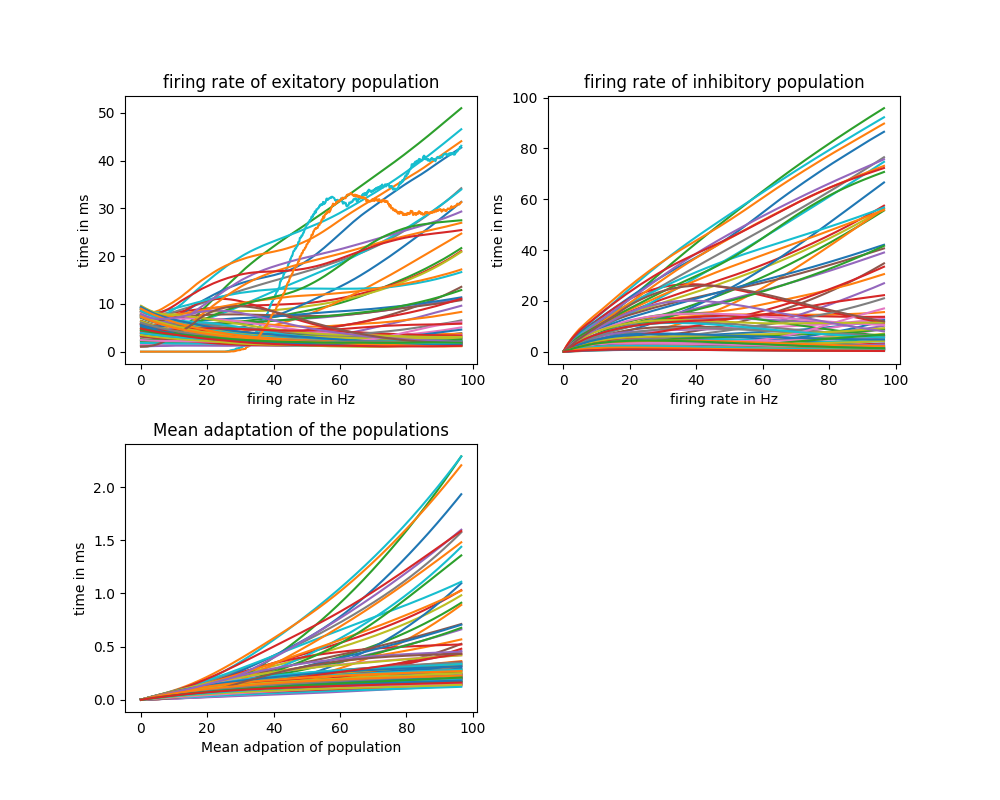

In [28]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(rate[0][0],np.concatenate(rate[0][1]).reshape(rate[0][1].shape[0],7,104,1)[:,0,:,0]*1e3)
plt.xlabel('firing rate in Hz')
plt.ylabel('time in ms')
plt.title('firing rate of exitatory population')
plt.subplot(222)
plt.plot(rate[0][0],np.concatenate(rate[0][1]).reshape(rate[0][1].shape[0],7,104,1)[:,1,:,0]*1e3)
plt.xlabel('firing rate in Hz')
plt.ylabel('time in ms')
plt.title('firing rate of inhibitory population')
plt.subplot(223)
plt.plot(rate[0][0],np.concatenate(rate[0][1]).reshape(rate[0][1].shape[0],7,104,1)[:,5,:,0])
plt.xlabel('Mean adpation of population')
plt.ylabel('time in ms')
plt.title('Mean adaptation of the populations')
plt.subplots_adjust(hspace=0.3)
plt.show()

## 3.2 Ploting data from Nest

In [30]:
data = get_data_all(folder_simulation+'/nest/')

/home/nest_elephant_tvb/analyse/get_data.py:105: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [31]:
data.keys()

dict_keys(['pop_1_ex_VM', 'pop_1_ex_W', 'pop_1_in_VM', 'pop_1_in_W', 'pop_1_ex', 'pop_2_ex', 'pop_1_in', 'pop_2_in'])

### 3.2.a Ploting the Voltage membrane

<IPython.core.display.Javascript object>


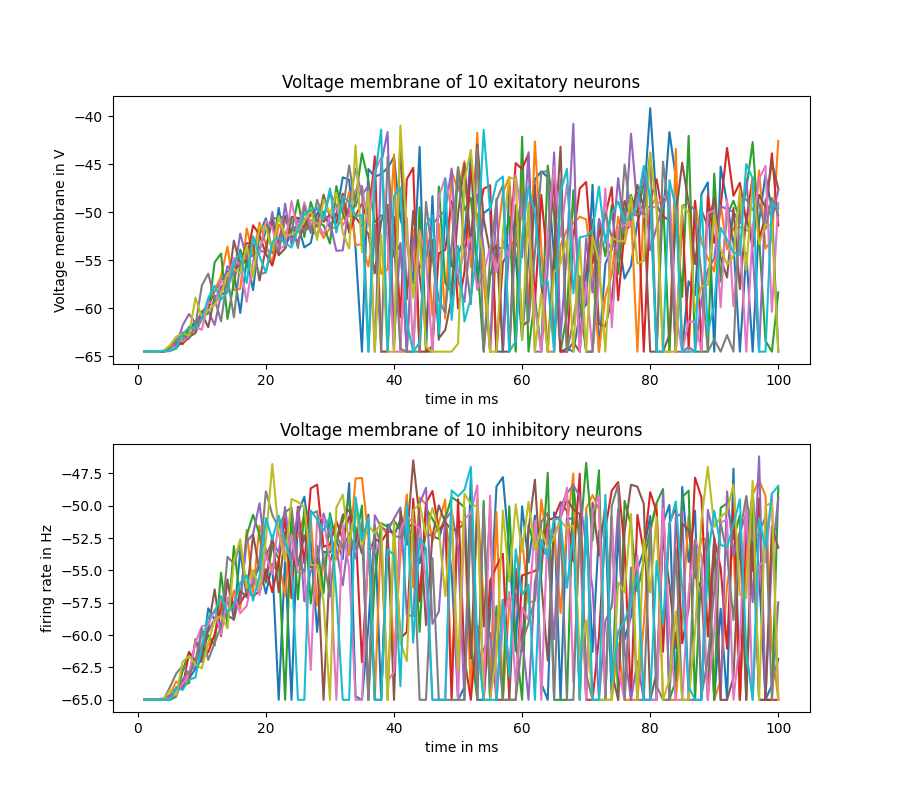

In [32]:
plt.figure(figsize=(9,8))
plt.subplot(211)
plt.plot(data['pop_1_ex_VM'][1],np.swapaxes(data['pop_1_ex_VM'][2],0,1))
plt.ylabel('Voltage membrane in V')
plt.xlabel('time in ms')
plt.title('Voltage membrane of 10 exitatory neurons')
plt.subplot(212)
plt.plot(data['pop_1_in_VM'][1],np.swapaxes(data['pop_1_in_VM'][2],0,1))
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('Voltage membrane of 10 inhibitory neurons')
plt.subplots_adjust(hspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


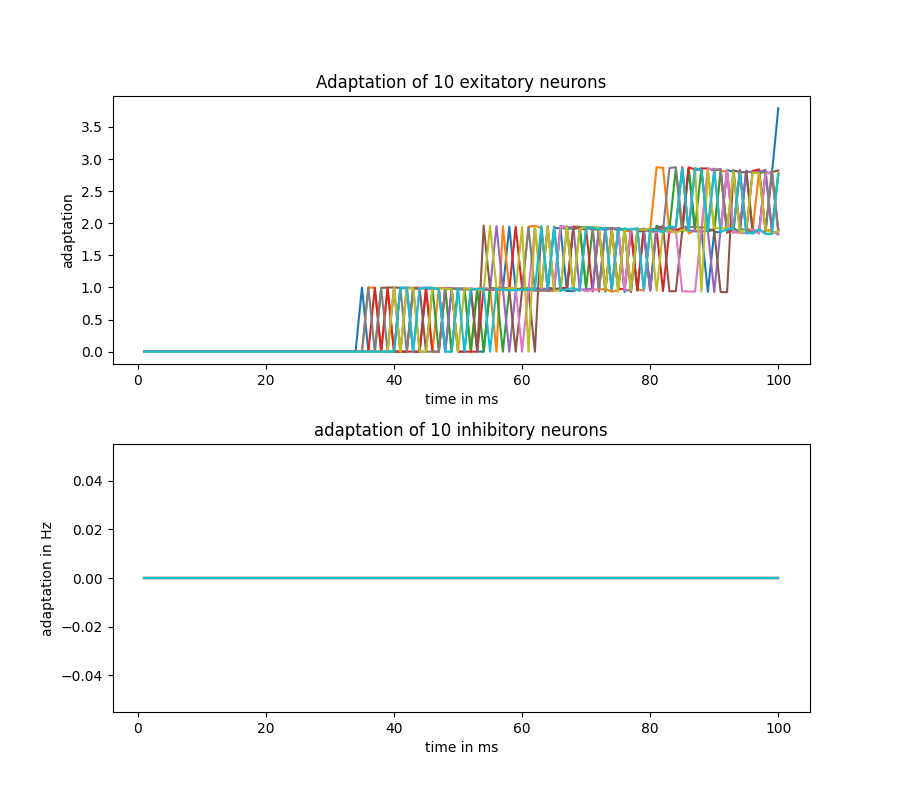

In [33]:
plt.figure(figsize=(9,8))
plt.subplot(211)
plt.plot(data['pop_1_ex_W'][1],np.swapaxes(data['pop_1_ex_W'][2],0,1))
plt.ylabel('adaptation')
plt.xlabel('time in ms')
plt.title('Adaptation of 10 exitatory neurons')
plt.subplot(212)
plt.plot(data['pop_1_in_W'][1],np.swapaxes(data['pop_1_in_W'][2],0,1))
plt.ylabel('adaptation in Hz')
plt.xlabel('time in ms')
plt.title('adaptation of 10 inhibitory neurons')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 3.2.b Spike trains of the first region

<IPython.core.display.Javascript object>


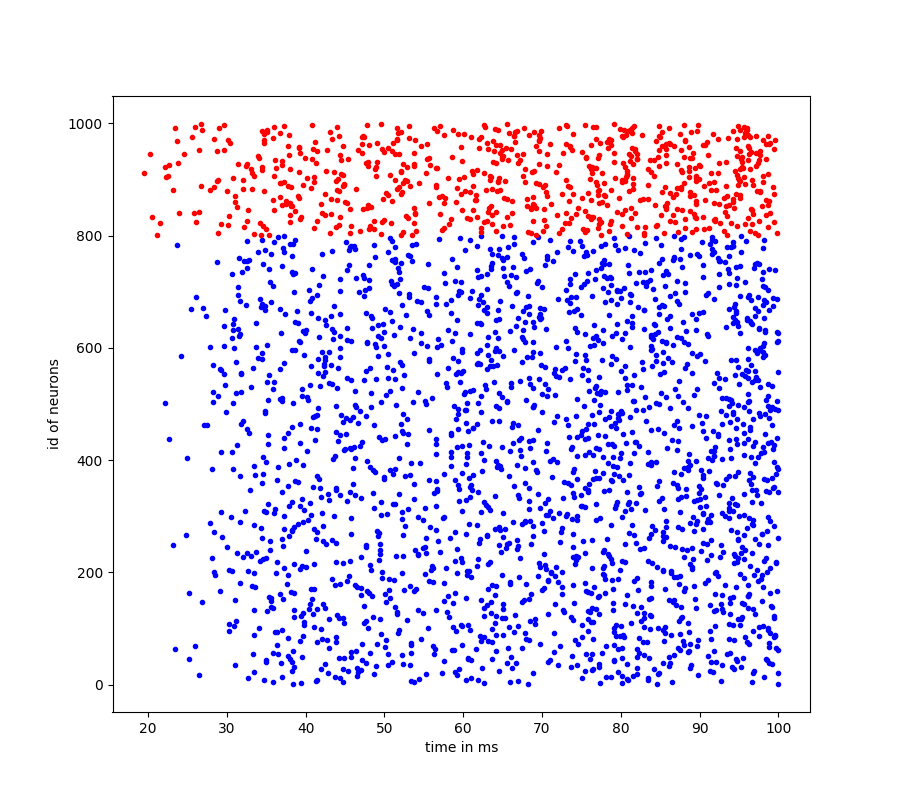

In [34]:
plt.figure(figsize=(9,8))
for i in range(data['pop_1_ex'][0].shape[0]):
    plt.plot(data['pop_1_ex'][1][i],np.repeat(data['pop_1_ex'][0][i],data['pop_1_ex'][1][i].shape[0]),'b.')
for i in range(data['pop_1_in'][0].shape[0]):
    plt.plot(data['pop_1_in'][1][i],np.repeat(data['pop_1_in'][0][i],data['pop_1_in'][1][i].shape[0]),'r.')
plt.ylabel('id of neurons')
plt.xlabel('time in ms')
plt.show()

<IPython.core.display.Javascript object>


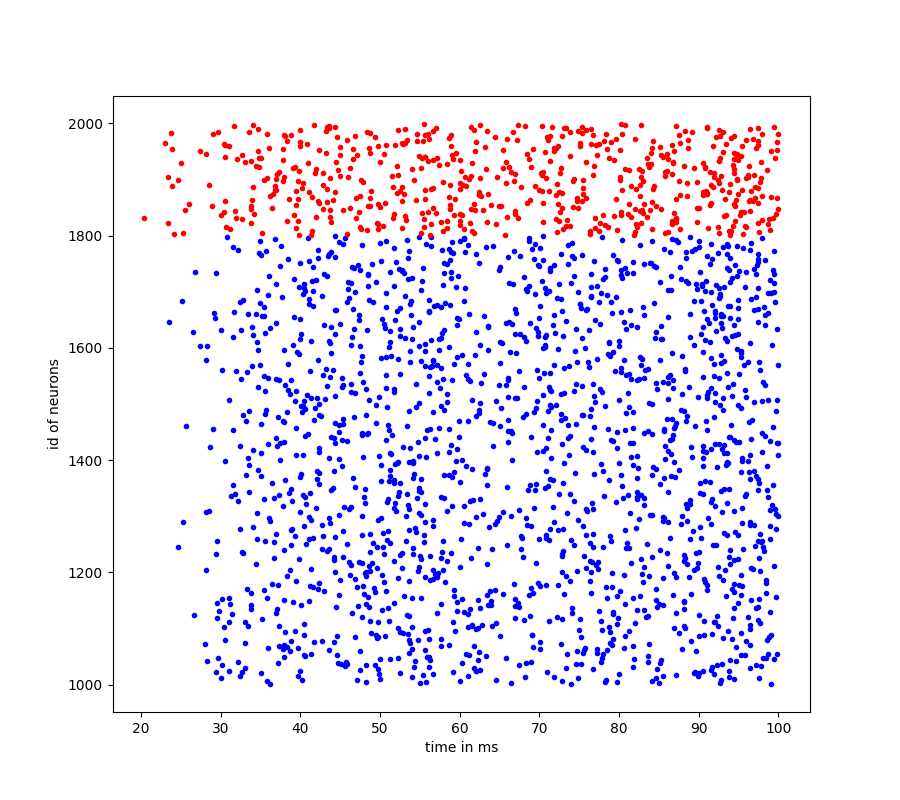

In [35]:
plt.figure(figsize=(9,8))
for i in range(data['pop_2_ex'][0].shape[0]):
    plt.plot(data['pop_2_ex'][1][i],np.repeat(data['pop_2_ex'][0][i],data['pop_2_ex'][1][i].shape[0]),'b.')
for i in range(data['pop_2_in'][0].shape[0]):
    plt.plot(data['pop_2_in'][1][i],np.repeat(data['pop_2_in'][0][i],data['pop_2_in'][1][i].shape[0]),'r.')
plt.ylabel('id of neurons')
plt.xlabel('time in ms')
plt.show()